# Wholesale Customers (clientes mayoristas) - versión 2

El objetivo de este proyecto es identificar y describir los distintos segmentos de clientes ocultos en los datos basandose en sus gastos anuales en diversas categorías de productos. Más información acerca de este dataset [aquí](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers).

Se comienza realizando un análisis exploratorio del dataset.

In [1]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectWC/data/wholesale_customers_data.csv")
df.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


Para entender qué significan las variables nominales, se ingresó al link del dataset en donde se encuentra la siguiente información:

CHANNEL: Horeca (Hotel/Restaurant/Café) or Retail channel

REGION: Lisnon, Oporto or Other

REGION Frequency: Lisbon: 77 - Oporto: 47 - Other Region: 316

CHANNEL Frequency: Horeca: 298 - Retail: 142

Para saber qué número corresponde a cada palabra calculo las frecuencias:

In [2]:
import numpy as np

print('Channel frequency:', np.sum(df['Channel']==1), np.sum(df['Channel']==2))
print('Region frequency:', np.sum(df['Region']==1), np.sum(df['Region']==2), np.sum(df['Region']==3))

Channel frequency: 298 142
Region frequency: 77 47 316


Para conocer la distribución de las variables grafico el pairplot del dataset:

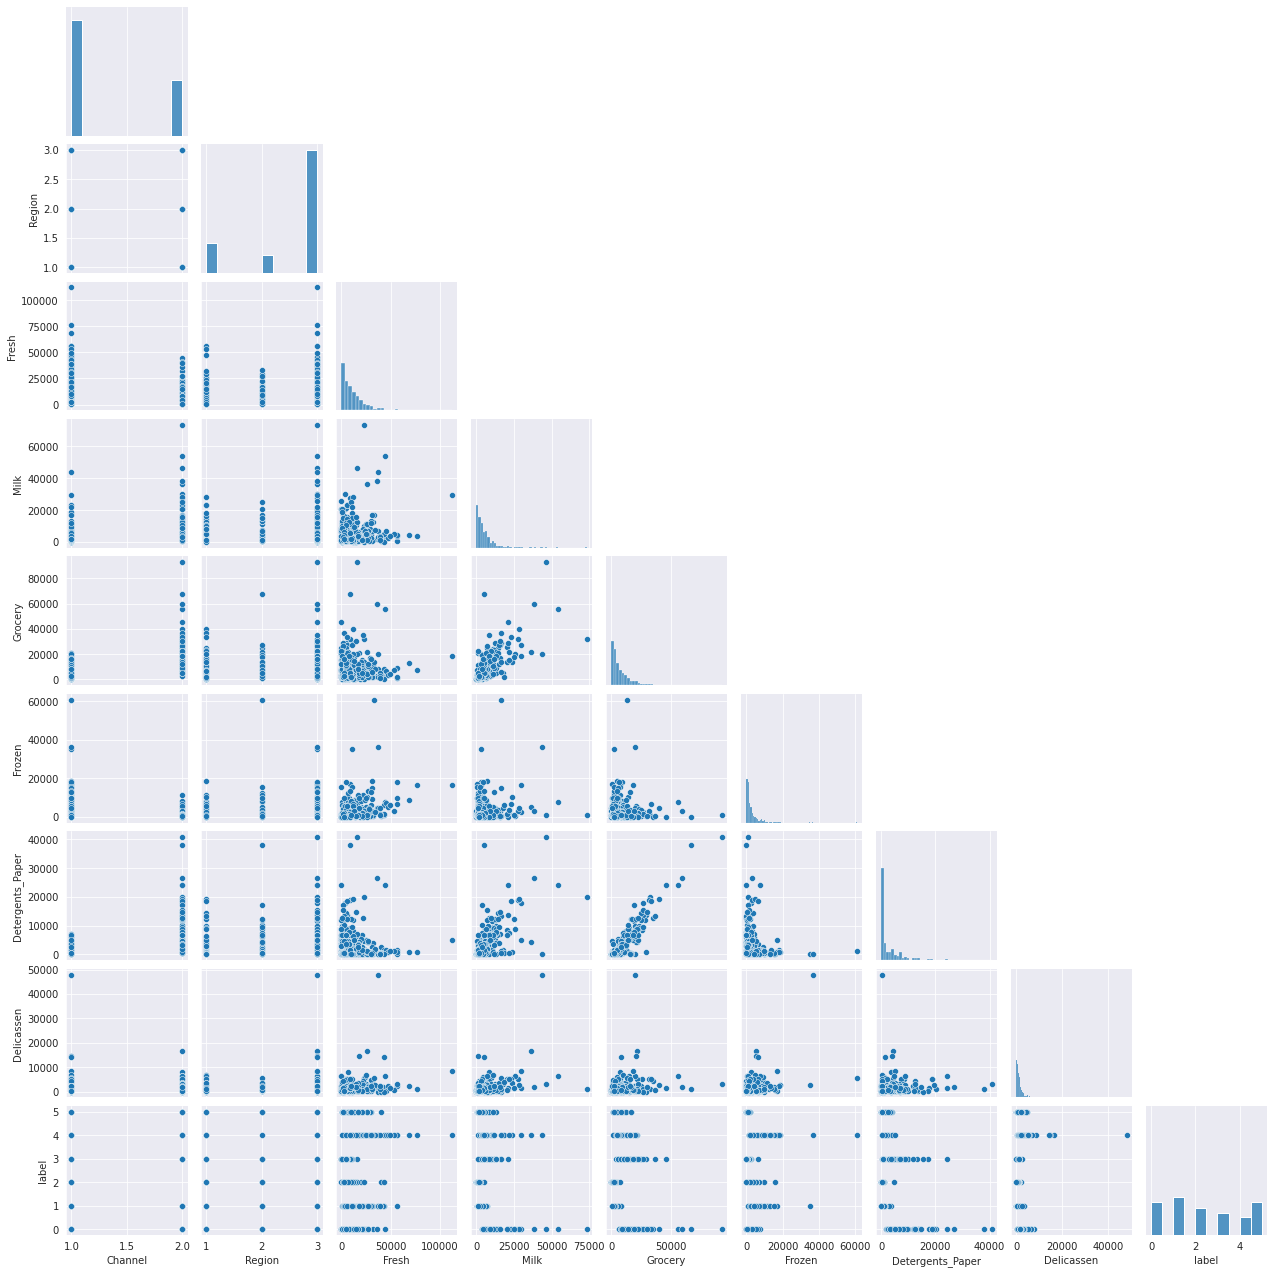

In [49]:
import seaborn as sns
sns.set_style('darkgrid')
sns.pairplot(df, corner=True, height=2)

Como se puede ver, hay 2 variables nominales y 6 numéricas. Si se utilizan estas dos variables nominales en algoritmos de clustering basados en distancias en el espacio de atributos, podrían inducir separaciones indeseadas entre grupos. Esto es porque aunque se normalicen, la distancia entre los distintos valores que toman estas variables sigue siendo considerable. Por esto se decide no tenerlas en cuenta en un primer análisis.

Con respecto a las variables numéricas, interesa conocer su distribución. Para ello se grafican sus histogramas más detalladamente.

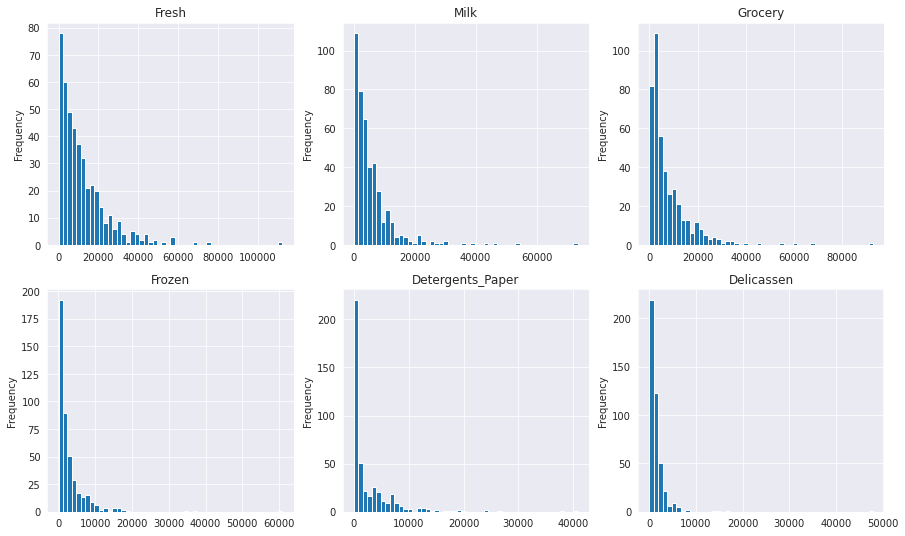

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15,9))
for r,c in np.ndindex(2,3):
    df[df.columns[2+r*3+c]].plot.hist(bins=50, ax=axes[r,c])
    axes[r,c].set_title(df.columns[2+3*r+c])

Los atributos graficados son siempre mayores a cero y tienen una distribución que decrece para valores altos, pudiéndose encontrar valores que alejan mucho de la media. Por esto, sería probable que los datos sigan una distribución log-normal. Además, esto se corresponde con el típico ejemplo de los ingresos monetarios de las personas que se asimila a una distribución log-normal, ya que aquí estamos viendo distribuciones de gastos monetarios.

Para analizar esto se grafica el histograma del logaritmo de los datos.

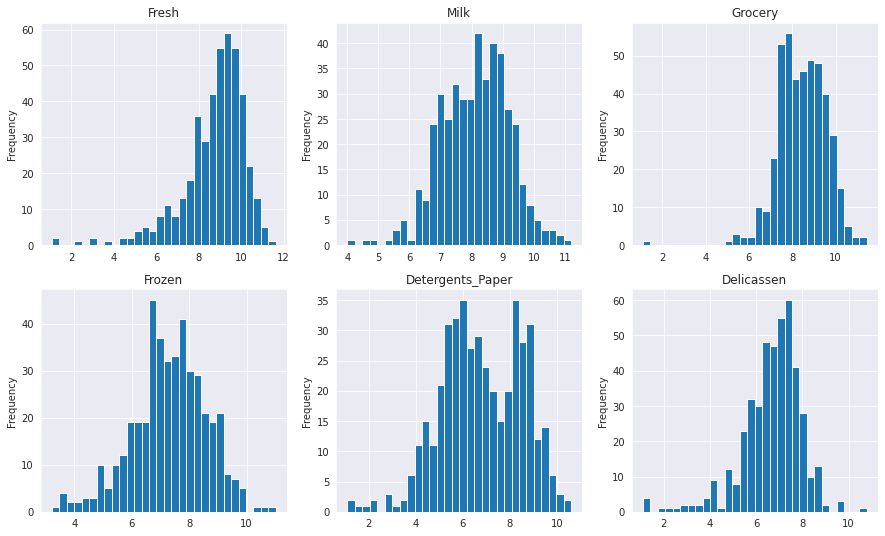

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(15,9))
for r,c in np.ndindex(2,3):
    np.log(df[df.columns[2+r*3+c]]).plot.hist(bins=30, ax=axes[r,c])
    axes[r,c].set_title(df.columns[2+3*r+c])

En escala logarítmica los histogramas se asimilan a la distribución normal, aunque no perfectamente. A continuación se muestran los gráficos Q-Q para determinar qué tan normales (es decir, log-normales) son.

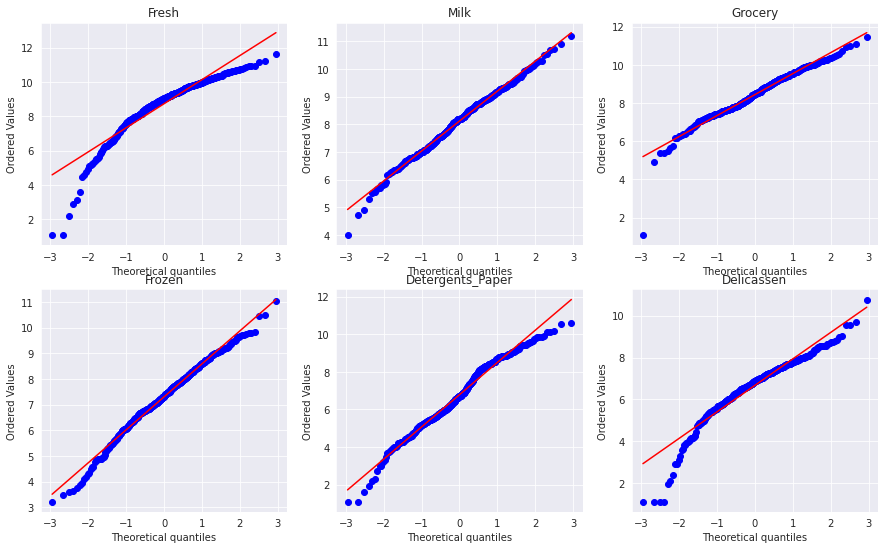

In [6]:
from scipy import stats

fig, axes = plt.subplots(2, 3, figsize=(15,9))
for r,c in np.ndindex(2,3):
    stats.probplot(np.log(df[df.columns[2+3*r+c]].values), dist='norm', plot=axes[r,c])
    axes[r,c].set_title(df.columns[2+3*r+c])

Las categorías Fresh, Detergents_Paper y Delicassen difieren de la recta, por lo cual su distribución no es tan normal (es decir, no es tan log-normal). A continuación utilizo la transformación Box-Cox para saber si la distribución de cada atributo se ajusta mejor a otra transformación que no necesariamente sea logarítmica. 

Best lambda for each category:

Fresh: 0.3
Milk: 0.07
Grocery: 0.13
Frozen: 0.09
Detergents_Paper: 0.06
Delicassen: 0.19


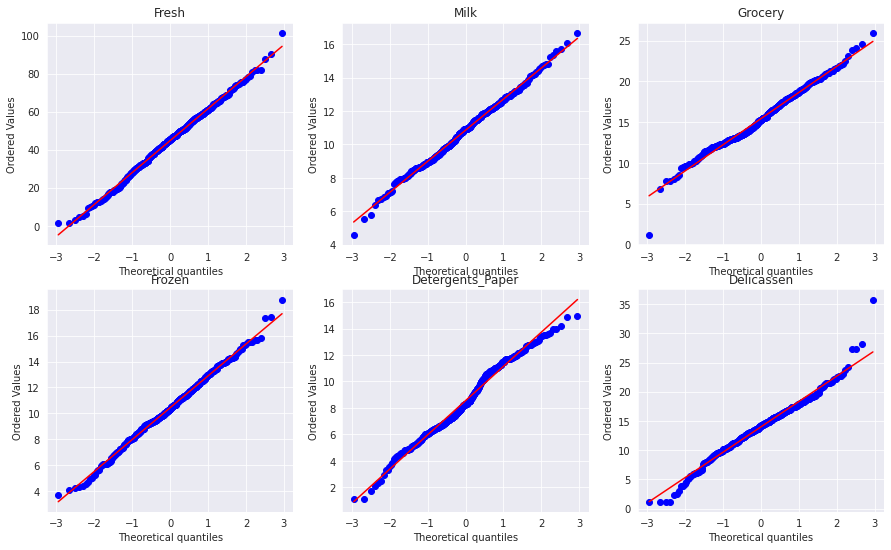

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15,9))
lambda_values = []
print('Best lambda for each category:\n')
for r,c in np.ndindex(2,3):
    xt, lam = stats.boxcox(df[df.columns[2+3*r+c]].values)
    lambda_values.append(lam)
    stats.probplot(xt, dist='norm', plot=axes[r,c])
    axes[r,c].set_title(df.columns[2+3*r+c])
    print(df.columns[2+3*r+c] + ': ' + str(np.round(lam, 2)))

Si bien varias de ellas mejoraron, algunas como Detergents_Paper todavía difieren un poco. Aun así, parece beneficioso que todas se asimilen lo más posible a una distribución normal antes de hacer clustering.

Se procede entonces a normalizar los datos a media cero y varianza uno.

In [ ]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler()
dfs = df.drop(columns=['Channel', 'Region']).copy()
for i in range(len(dfs.columns)):
    dfs[dfs.columns[i]] = stats.boxcox(dfs[dfs.columns[i]], lmbda=lambda_values[i])

dfs = pd.DataFrame(data=s.fit_transform(dfs.values), columns=dfs.columns)

# Clustering

La cantidad de grupos o segmentos de clientes es en principio desconocida. Para determinarla se propone utilizar K-Means con el método del "codo", el cual consiste en analizar cómo decrece la inercia (o suma de cuadrados dentro de cada cluster) al aumentar K y seleccionar el K donde se produzca el "quiebre" o "codo". Para encontrar este punto se grafica además la derivada segunda de la curva.

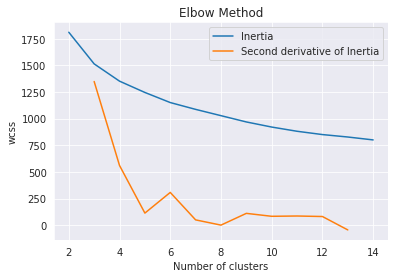

In [9]:
from sklearn.cluster import KMeans
wcss = []
for i in range(2,15):
    km=KMeans(n_clusters=i, init='k-means++', random_state=0)
    km.fit(dfs.values)
    wcss.append(km.inertia_)
plt.plot(range(2,15), wcss, range(3,14), 10*np.diff(np.diff(wcss)))
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.legend(['Inertia', 'Second derivative of Inertia'])
plt.show()

Como se puede ver, la curva azul no tiene un codo o quiebre bien pronunciado para valores razonables de K. Podría decirse que hay un codo en K=3, pero dado el tamaño del dataset, 3 grupos no parece un valor representativo. Analizando la derivada segunda se puede ver que decae hasta K=5 y luego tiene un máximo en K=6. Para K>6 no se encuentran otros máximos locales pronunciados. Podría concluirse entonces que si bien 6 parece ser la mejor opción, valores entre 5 y 7 u 8 podrían ser candidatos también, ya que el "codo" no es muy pronunciado.

A continuación se muestra cómo quedan los clusters en un pairplot.

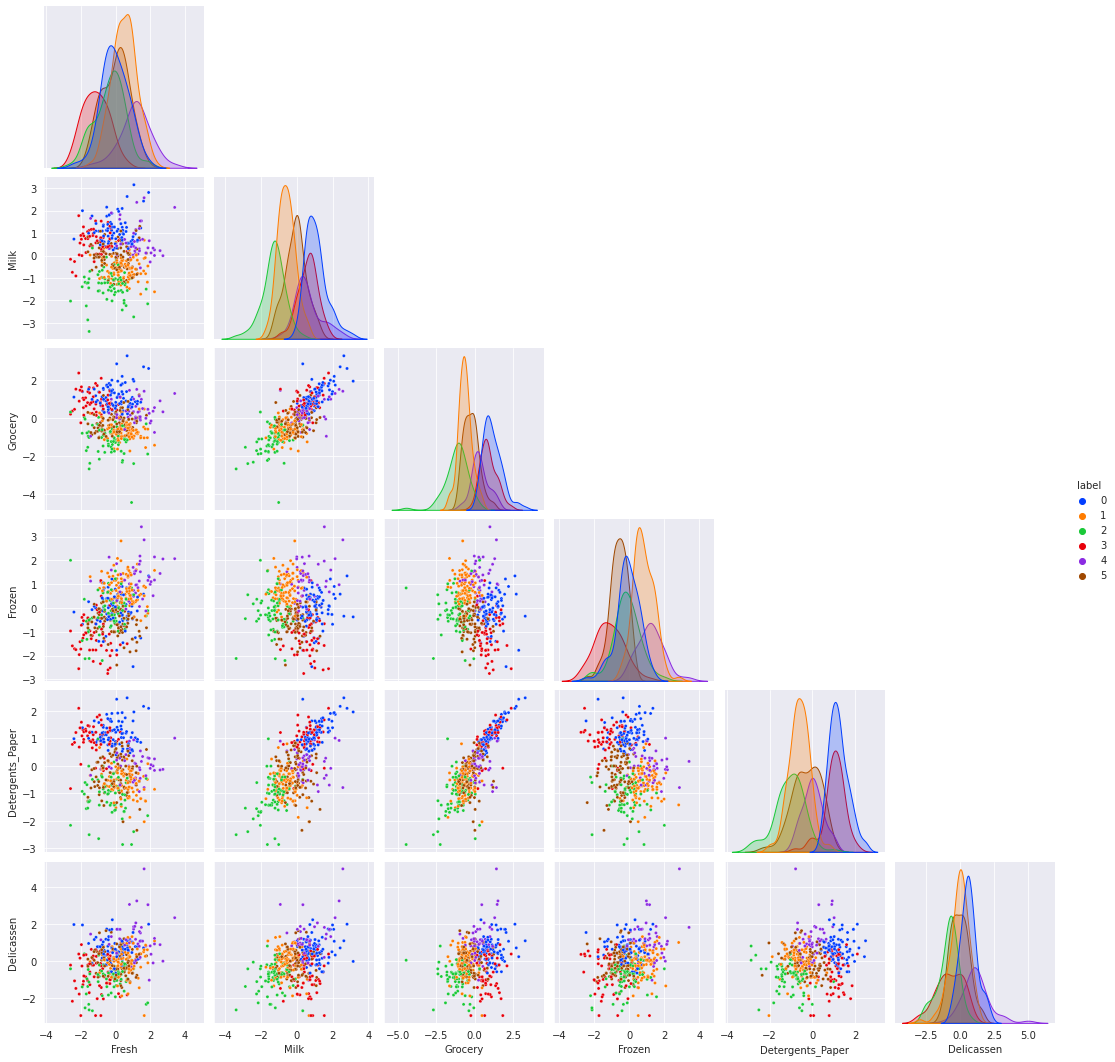

In [51]:
km = KMeans(n_clusters=6, init='k-means++', random_state=0)
km.fit(dfs.values)
dfs = pd.concat([dfs, pd.DataFrame({'label':km.labels_})], axis=1)
sns.pairplot(dfs, hue='label', palette='bright', corner=True, plot_kws={"s": 10})

Interesa también ver cómo quedan los clusters sin normalizar los datos.

(-1500.0, 30000.0)

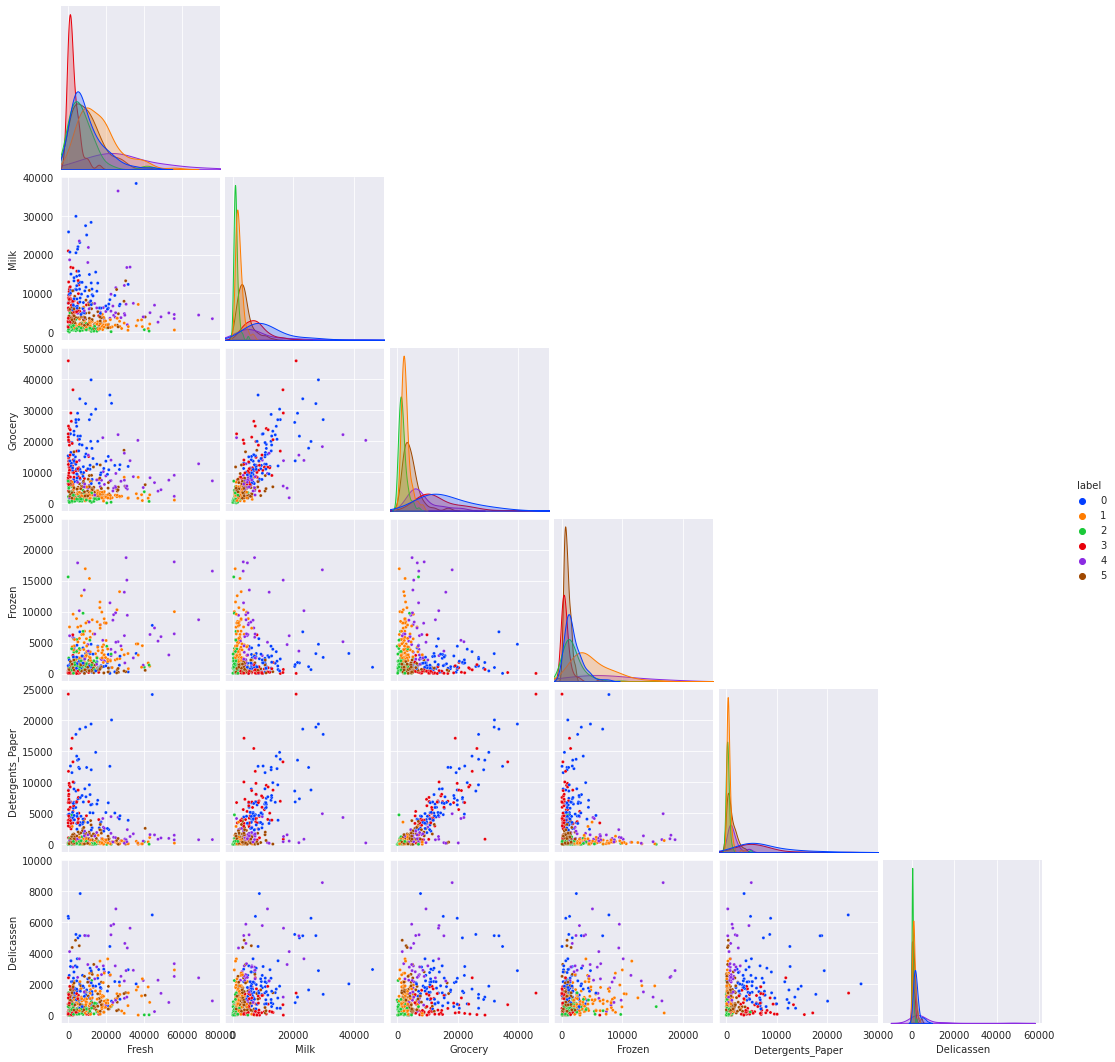

In [59]:
df = pd.concat([df, pd.DataFrame({'label':km.labels_})], axis=1)
p = sns.pairplot(df.drop(columns=['Channel','Region']), hue='label', 
             palette='bright', corner=True, plot_kws={"s": 10})
p.axes[1,0].set_xlim((-4000,80000))
p.axes[1,0].set_ylim((-2000,40000))
p.axes[2,0].set_ylim((-2500,50000))
p.axes[2,1].set_xlim((-2500,50000))
p.axes[3,0].set_ylim((-1250,25000))
p.axes[3,2].set_xlim((-2500,50000))
p.axes[4,0].set_ylim((-1250,25000))
p.axes[4,3].set_xlim((-1250,25000))
p.axes[5,0].set_ylim((-500,10000))
p.axes[5,4].set_xlim((-1500,30000))

En todos estos gráficos, tanto normalizados como no normalizados se puede ver una clara separación entre los grupos y que el tamaño de los mismos es bastante balanceado.

# Descripción de los segmentos de clientes

Se comienza realizando un gráfico de barras que muestra el gasto promedio de los integrantes de cada grupo en cada una de las categorías de productos. Las líneas negras marcan el intervalo de confianza del 95%.

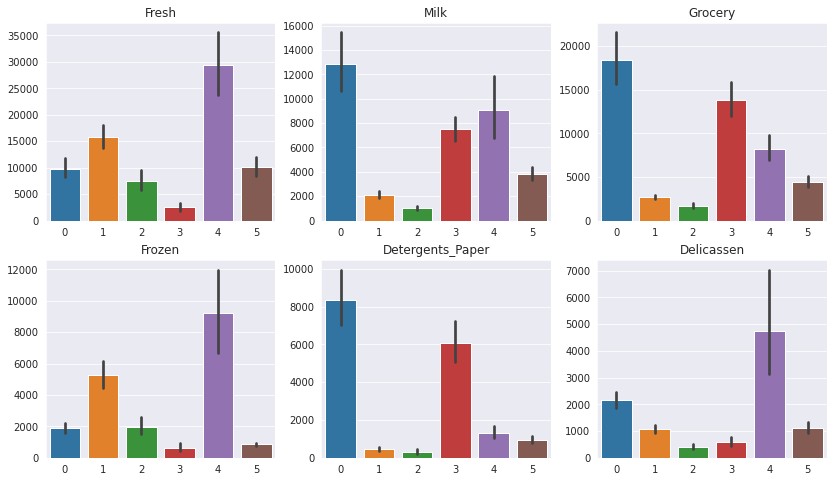

In [61]:
fig, axes = plt.subplots(2, 3, figsize=(14,8))
for r,c in np.ndindex((2,3)):
    sns.barplot(ax=axes[r,c], x='label', y=df.columns[3*r+c+2], data=df, 
                ci=95, estimator=np.mean)
    axes[r,c].set_title(df.columns[3*r+c+2])
    axes[r,c].set_ylabel('')    
    axes[r,c].set_xlabel('')

En este gráfico de barras se puede llegar a conclusiones como que el grupo 4 (violeta) es el que más gasta más en "Fresh" o que los únicos grupos que gastan mucho en "Detergents_Paper" son el 0 (azul) y el 3 (rojo).

Por otro lado, interesa conocer la distribución de las variables nominales que no fueron tenidas en cuenta en el clustering. A continuación se muestran gráficos de torta que indican la proporción de consumo que fue realizado en los canales "Hotel/Restaurant/Café" o en "Retail" por cada grupo.

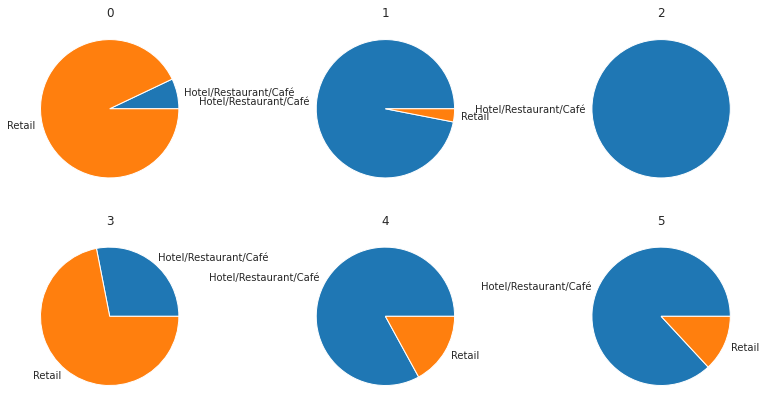

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(14,7))
channels = ['Hotel/Restaurant/Café', 'Retail']
for r,c in np.ndindex((2,3)):
    axes[r,c].set_title(str(3*r+c))
    x = df.iloc[df.values[:,-1]==3*r+c, 0].values
    axes[r,c].pie(np.bincount(x)[1:3],
                  labels=[channels[i-1] for i in np.unique(x)])

Resulta interesante ver que existe una fuerte correlación entre tipo de consumo (o grupo al que se pertenece) y el atributo Channel. Tal es así que los grupos 1 y 2 casi no tienen consumo vía Retail y lo contrario sucede para el grupo 0.

A continuación se muestra el mismo gráfico pero para el atributo "Region".

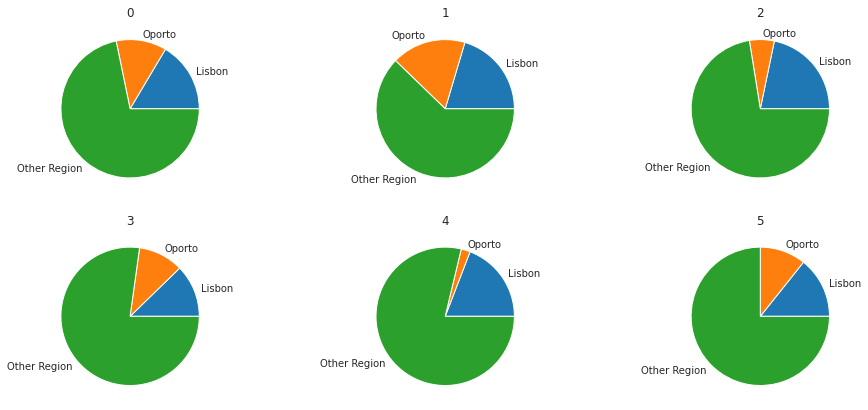

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(16,7))
for r,c in np.ndindex((2,3)):
    axes[r,c].set_title(str(3*r+c))
    axes[r,c].pie(np.bincount(df.iloc[df.values[:,-1]==3*r+c, 1].values)[1:4],
                  labels=['Lisbon', 'Oporto', 'Other Region'])

Finalmente, podría ser útil saber para cada categoría cuánto porcentaje representa cada grupo. 

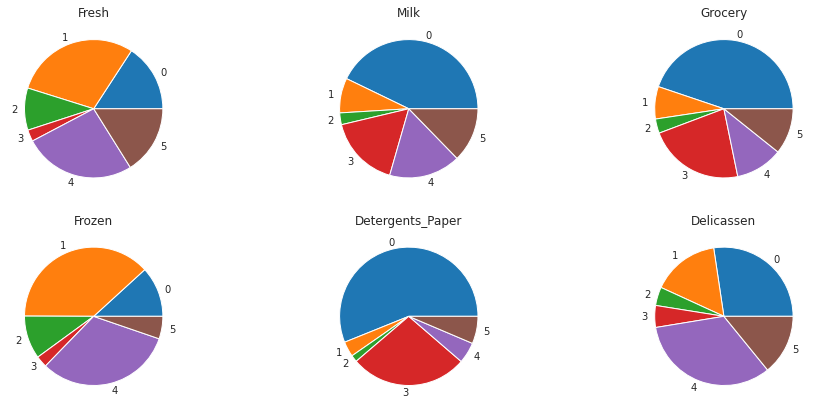

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(16,7))
for r,c in np.ndindex((2,3)):
    spend = [np.sum(df.iloc[df.values[:,-1]==label, 2+3*r+c]) for label in range(6)]
    axes[r,c].set_title(df.columns[2+3*r+c])
    axes[r,c].pie(spend, labels=[str(x) for x in range(6)])

En este último gráfico puede verse una clara correlación entre las categorías "Fresh" y "Frozen", y también entre "Milk", "Grocery" y "Detergents_Paper". Esto podría indicar que si un cliente compra productos de una cierta categoría, es muy probable que también compre productos de las categorías que están correlacionadas.

# Conclusión

El clustering resulta muy útil para este tipo de aplicaciones, ayudando a extraer patrones de comportamiento de los clientes que luego pueden ser utilizados para incrementar las ventas o mejorar la logística o servicios que provee el vendedor.

Como algoritmo de clustering se utilizó K-Means con el método del "codo" para determinar la cantidad de clusters. Este enfoque resulta sencillo, es muy utilizado en la práctica y parece haber dado buenos resultados para este caso. Aun así, hay muchos otros algoritmos y enfoques interesantes para probar.

Se destaca la importancia del análisis exploratorio del dataset y la normalización de los datos antes de aplicar clustering. Comparando los resultados con intentos anteriores (versión 1) en donde no se tuvo en cuenta la distribución de los datos, en esta versión se obtuvieron grupos más diferenciados entre sí y de tamaños más balanceados.